# Cross-subject decoding - hidden layer identification 
## Uses RSM of hidden/recurrent layer in ANN model (Model9a)

#### Takuya Ito
#### 05/15/2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools
import nibabel as nib
from importlib import reload
import sklearn

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [3]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



projectdir = '/home/ti61/f_mc1689_1/SRActFlow/'

# Using final partition
networkdef = np.loadtxt(projectdir + 'data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# 1.0 Run across subject decoding on RED SR rules
### 4-way decoding
* both red
* notboth red
* either red
* neither red

## 1.1 Load data for rules and stimulus representations

In [4]:
# gsr = True
n_features = 28 # 12 rules, 16 stim combos
data_task = np.zeros((len(glasser2),n_features,len(subjNums)))
rules = ['Logic','Sensory','Motor']
stimuli = ['colorStim','oriStim','pitchStim','constantStim']


scount = 0
for subj in subjNums:
    print('Loading subject', subj)
    indstart = 0
    indend = 4
    for rule in rules:
        data_task[:,indstart:indend,scount] = tools.loadRuleEncoding(subj,rule)
        indstart += 4
        indend += 4
    
    for stim in stimuli:
        data_task[:,indstart:indend,scount] = tools.loadInputActivity(subj,stim)
        indstart += 4
        indend += 4
    
    scount += 1


Loading subject 013


/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


Loading subject 014
Loading subject 016
Loading subject 017
Loading subject 018
Loading subject 021
Loading subject 023
Loading subject 024
Loading subject 026
Loading subject 027
Loading subject 028
Loading subject 030
Loading subject 031
Loading subject 032
Loading subject 033
Loading subject 034
Loading subject 035
Loading subject 037
Loading subject 038
Loading subject 039
Loading subject 040
Loading subject 041
Loading subject 042
Loading subject 043
Loading subject 045
Loading subject 046
Loading subject 047
Loading subject 048
Loading subject 049
Loading subject 050
Loading subject 053
Loading subject 055
Loading subject 056
Loading subject 057
Loading subject 058
Loading subject 062
Loading subject 063
Loading subject 066
Loading subject 067
Loading subject 068
Loading subject 069
Loading subject 070
Loading subject 072
Loading subject 074
Loading subject 075
Loading subject 076
Loading subject 077
Loading subject 081
Loading subject 085
Loading subject 086
Loading subject 087


# Run group-level RDM comparisons

#### Run RSA and construct RSM

In [5]:
group_rsm = np.zeros((n_features, n_features, nParcels))

group_data_task = np.mean(data_task,axis=2)
for parcel in range(nParcels):
    parcel_ind = np.where(glasser2==parcel+1)[0]
    tmp = np.corrcoef(group_data_task[parcel_ind,:].T)
    np.fill_diagonal(tmp,0)
    tmp = np.arctanh(tmp)
    group_rsm[:,:,parcel] = tmp.copy()
        

In [7]:
ann_rsm = np.loadtxt(projectdir + 'data/results/MODEL/ANN1280_HiddenLayerRSM_NoDynamics.csv')
triu_ind = np.triu_indices(n_features,k=1)
rsm_similarities = np.zeros((nParcels,3)) # r, p, q
# group_rsm = np.mean(rsm,axis=3)
for parcel in range(nParcels):
#         r, p = stats.pearsonr(np.arctanh(ann_rsm[triu_ind]),rsm[:,:,parcel,s][triu_ind])
    r, p = stats.spearmanr(np.arctanh(ann_rsm[triu_ind]),group_rsm[:,:,parcel][triu_ind])
    rsm_similarities[parcel,0] = r
    rsm_similarities[parcel,1] = p
rsm_similarities[:,2] = mc.fdrcorrection0(rsm_similarities[:,1])[0]
    
    
max_ind = np.where(rsm_similarities[:,0]==np.max(rsm_similarities[:,0]))[0]
min_ind = np.where(rsm_similarities[:,0]==np.min(rsm_similarities[:,0]))[0]
print('Max RSM similarity:', np.max(rsm_similarities[:,0]), 'ROI =', max_ind+1)
print('Min RSM similarity:', np.min(rsm_similarities[:,0]), 'ROI =', min_ind+1)


Max RSM similarity: 0.7162909069014064 ROI = [114]
Min RSM similarity: -0.21678353995704555 ROI = [196]


#### Save out an ordered list from highest-to-lowest variance explained for ActFlow mapping

In [35]:
tmp = rsm_similarities[:,0]
new = sorted(range(len(tmp)), key=lambda k: -tmp[k])
print("Top 10 MOST similar", new[:10])

leastsimilar = sorted(range(len(tmp)), key=lambda k: tmp[k])
print("Top 10 least similar", leastsimilar[:10])

# np.savetxt('/projects3/SRActFlow/data/results/GroupfMRI/RSA/RSA_Similarity_SortedRegions2.txt',new)

Top 10 MOST similar [113, 279, 116, 216, 293, 226, 104, 76, 208, 221]
Top 10 least similar [195, 19, 337, 16, 15, 157, 199, 6, 185, 198]


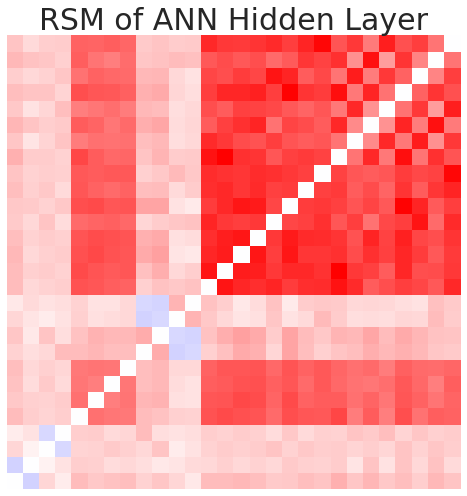

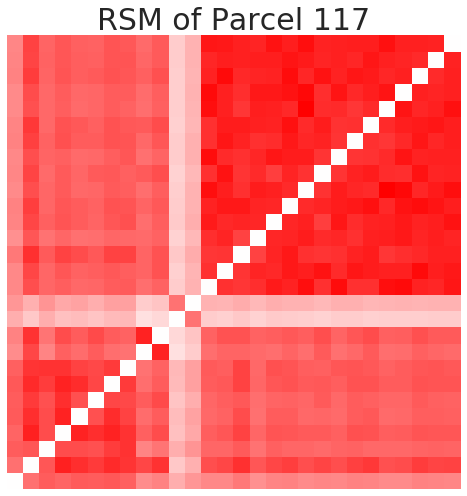

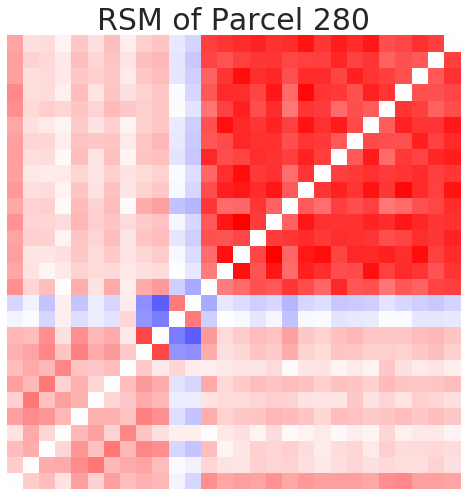

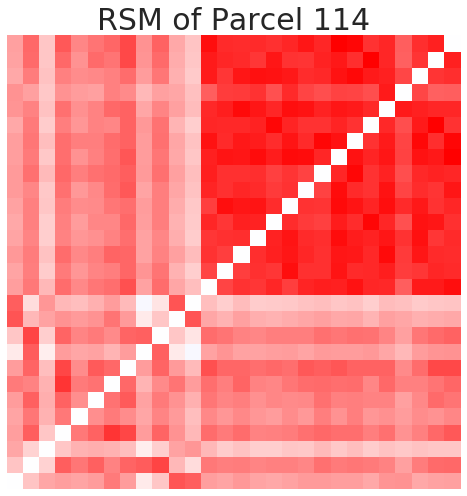

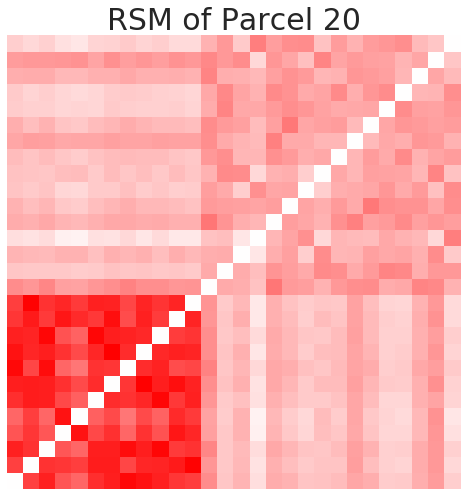

In [50]:
plt.figure(figsize=(7,7))
# ax = sns.heatmap(np.arctanh(ann_rsm),cmap='bwr', center=0,square=True,cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(np.arctanh(ann_rsm),cmap='bwr', center=0,square=True,xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of ANN Hidden Layer", fontsize=30, fontname="Arial")
plt.tight_layout()
plt.savefig('RSM_ANN_HiddenLayer.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 116
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 279
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)

plt.figure(figsize=(7,7))
parcelno = 113
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 19
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)



In [29]:
#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
rsm_similarity_64k = np.zeros((glasser2.shape[0],3))
top_regions = np.zeros((glasser2.shape[0],4))

roicount = 0
for roi in range(nParcels):
    vertex_ind = np.where(glasser2==roi+1)[0]
    rsm_similarity_64k[vertex_ind,0] = rsm_similarities[roicount,0]
    rsm_similarity_64k[vertex_ind,1] = rsm_similarities[roicount,1]
    rsm_similarity_64k[vertex_ind,2] = np.multiply(rsm_similarities[roicount,2],rsm_similarities[roicount,0]) # threshold q < 0.05
    if roi in new[:5]: top_regions[vertex_ind,0] = 1
    if roi in new[:10]: top_regions[vertex_ind,1] = 1
    if roi in new[:15]: top_regions[vertex_ind,2] = 1
    if roi in new[:20]: top_regions[vertex_ind,3] = 1
        

    roicount += 1
    
# #### 
# # Write file to csv and run wb_command
# outdir = projectdir + 'data/results/MAIN/RSA/'
# filename = 'rsaSimilarity_v2'
# np.savetxt(outdir + filename + '.csv', rsm_similarity_64k, fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)


# # Write file to csv and run wb_command
# outdir = projectdir + 'data/results/MAIN/RSA/'
# filename = 'rsaSimilarity_topRegionsMask_v2'
# np.savetxt(outdir + filename + '.csv', top_regions, fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)

0